# Cargar imagen

La imagen corresponde a un paciente diagnosticado con Melanoma maligno invasivo. El objetivo de este análisis es segmentar la región que corresponde al melanoma y descartar otras características de la imagen como vellos.

* Imagen del Departamento de Dermatología, Clínica Hospital de Barcelona (NA). Recuperado de The International Skin Imaging Collaboration (enero, 2025). https://www.isic-archive.com 

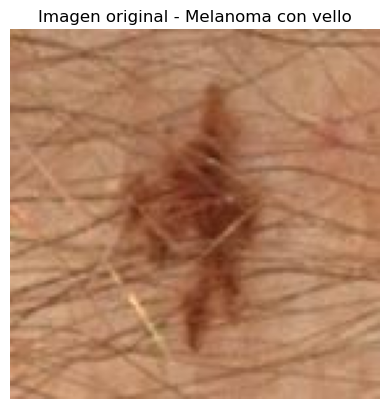

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar imagen
imagen = cv2.imread("ISIC_3957869.jpg")  # BGR
# Convertir a RGB para visualización con matplotlib
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

plt.imshow(imagen_rgb)
plt.title("Imagen original - Melanoma con vello")
plt.axis('off')
plt.show()


# Operaciones morfológicas de preprocesamiento

Es necesario eliminar de la imagen el vello para que no interfiera en el procesado posterior donde se segmentará. Para esto es conveniente usar la operación de Black-hat.

## Operación black-hat y relleno con inpainting

Primero se realiza la operación black-hat para detectar y eliminar estructuras finas (cabellos). Posteriormente se hace un inpainting para rellenar con píxeles similares a los del fondo. De este modo, se pretende limpiar la imagen y dejarla lista para analizar el objetivo: el melanoma.

Se eligió empíricamente el tamaño de la estructura elemental para poder detectar los vellos a la vez que se conservaba la mayor cantidad posible de información visible del melanoma. Del mismo modo con el threshold para umbralizar la aplicación del filtro.

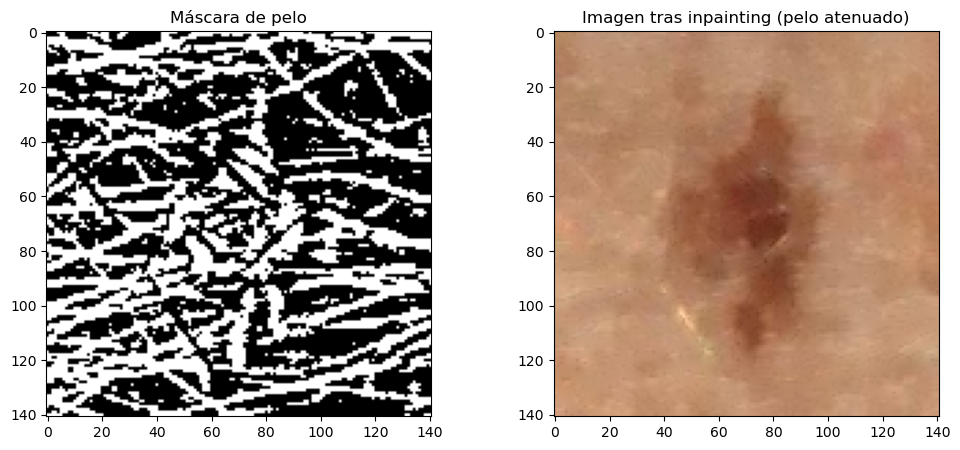

In [2]:
# Convertir a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar black-hat para resaltar lineas oscuras finas
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# Umbralizar la imagen de blackhat para aislar pelos
_, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

# Inpainting: Rellenar las zonas de pelo
# cv2.INPAINT_TELEA o cv2.INPAINT_NS, a probar
imagen_inpaint_bgr = cv2.inpaint(imagen, hair_mask, 3, cv2.INPAINT_TELEA)

# Convertimos a RGB para mostrar
imagen_inpaint_rgb = cv2.cvtColor(imagen_inpaint_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(hair_mask, cmap='gray')
plt.title("Máscara de pelo")

plt.subplot(1,2,2)
plt.imshow(imagen_inpaint_rgb)
plt.title("Imagen tras inpainting (pelo atenuado)")
plt.show()


## Conversión de RGB a HSV

Con el fin de obtener una mejor segmentación, se convierten los canales de la imagen de RGB a HSV, este último contempla el tono, saturación y valor/luminosidad en cada uno de sus canales. Para este caso es de interés el canal V para detectar cambios en la luminosidad de la imagen.

In [3]:
imagen_hsv = cv2.cvtColor(imagen_inpaint_bgr, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(imagen_hsv)


# Segmentación

Primero se realiza una umbralización con el canal de luminosidad V.

In [4]:
print("Mínimo:", V.min(), "Máximo:", V.max(), "Promedio:", V.mean())

Mínimo: 102 Máximo: 255 Promedio: 181.97490065892057


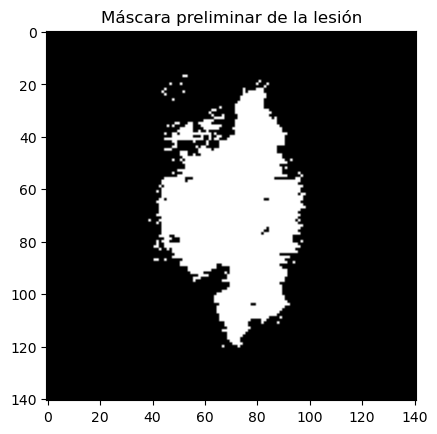

In [5]:
# Enviar como parámetro el canal V. 
# Se utiliza el método THRESH_OTSU para calcular automáticamente el threshold apropiado
_, mask_lesion = cv2.threshold(V, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(mask_lesion, cmap = "gray")
plt.title("Máscara preliminar de la lesión")
plt.show()

## Filtrado morfológico

Se puede observar que la imagen segmentada tiene espacios y agujeros en la delimitación. Por lo que sería conveniente consolidarla usando operadores morfológicos.

Para este caso se usará el operador de Apertura y Clausura.

* Closing (MORPH_CLOSE): rellena huecos en el interior de la lesión.
* Opening (MORPH_OPEN): elimina puntitos de ruido que puedan quedar fuera de la lesión.

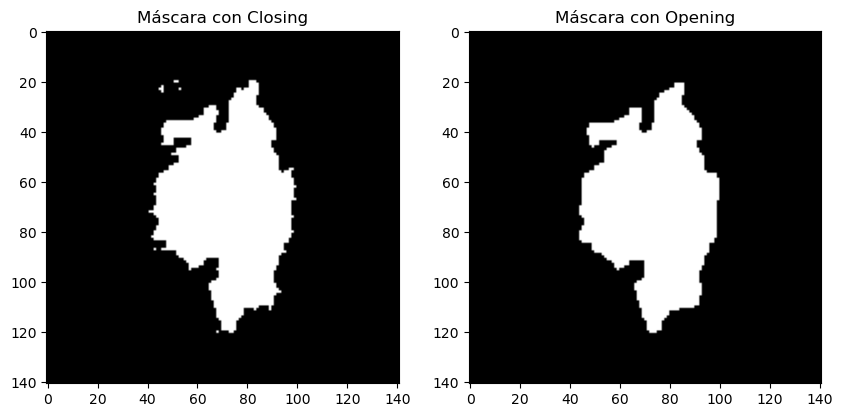

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
mask_close = cv2.morphologyEx(mask_lesion, cv2.MORPH_CLOSE, kernel)
mask_open = cv2.morphologyEx(mask_close, cv2.MORPH_OPEN, kernel)

final_mask = mask_open  # mascara final más “limpia”

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mask_close, cmap="gray")
plt.title("Máscara con Closing")

plt.subplot(1,2,2)
plt.imshow(mask_open, cmap="gray")
plt.title("Máscara con Opening")
plt.show()

## Filtrado por conectividad

Ahora se usa un filtro de conectividad para asegurarse que no hayan píxeles sueltos que puedan afectar la máscara final de la lesión

In [7]:
num_labels, labels_im = cv2.connectedComponents(final_mask)
max_area = 0
max_label = 0

for label_num in range(1, num_labels):
    comp = (labels_im == label_num)
    area = np.sum(comp)
    if area > max_area:
        max_area = area
        max_label = label_num

lesion_mask = (labels_im == max_label).astype(np.uint8)

# Visualización para comparar contra original

Finalmente, se visualiza la segmentación generada y se superpone a la imagen original para validar resultados.

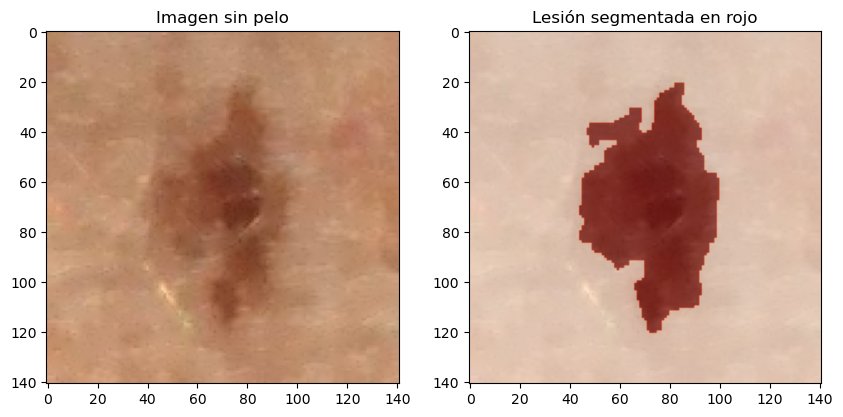

In [8]:
# Convertir la imagen base a RGB
imagen_inpaint_rgb = cv2.cvtColor(imagen_inpaint_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imagen_inpaint_rgb)
plt.title("Imagen sin pelo")

plt.subplot(1,2,2)
plt.imshow(imagen_inpaint_rgb)
plt.imshow(lesion_mask, cmap='Reds', alpha=0.5)
plt.title("Lesión segmentada en rojo")

plt.savefig("segmentacion melanoma.png", bbox_inches='tight', dpi=150)
plt.show()
plt.close()

